In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## Data Understanding

In [12]:
# Fungsi untuk memuat dan meresize gambar
def load_and_resize_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    return image

# Lokasi folder yang berisi gambar-gambar
folder_paths = {
    "matang": "D:/ta-rafi/dataset_mangga/matang",
    "matang_muda": "D:/ta-rafi/dataset_mangga/matang_muda",
    "mentah": "D:/ta-rafi/dataset_mangga/mentah"
}

In [13]:
# List untuk menyimpan data gambar dan label
images = []
labels = []

# Loop melalui setiap kelas
for k, path in folder_paths.items():
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        if os.path.isfile(image_path):
            image = load_and_resize_image(image_path, (224, 224))  # Ubah ukuran gambar menjadi (224, 224)
            images.append(image)
            labels.append(k)

# Ubah ke dalam numpy array
images = np.array(images)
labels = np.array(labels)

In [14]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Acak data
images, labels = shuffle(images, labels, random_state=42)

# Bagi data menjadi set pelatihan dan pengujian dengan menjaga distribusi kelas yang sama
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)

print("Jumlah data pelatihan:", len(X_train))
print("Jumlah data pengujian:", len(X_test))

Jumlah data pelatihan: 540
Jumlah data pengujian: 60


In [15]:
# Dictionary untuk menyimpan jumlah masing-masing kelas dalam set data pelatihan dan pengujian
train_kelas_counts = {k: 0 for k in folder_paths.keys()}
test_kelas_counts = {k: 0 for k in folder_paths.keys()}

# Hitung jumlah masing-masing kelas dalam set data pelatihan
for label in y_train:
    train_kelas_counts[lb.classes_[np.argmax(label)]] += 1

# Hitung jumlah masing-masing kelas dalam set data pengujian
for label in y_test:
    test_kelas_counts[lb.classes_[np.argmax(label)]] += 1

# Cetak jumlah masing-masing kelas dalam set data pelatihan dan pengujian
print("\nJumlah masing-masing kelas dalam set data pelatihan:")
for k, count in train_kelas_counts.items():
    print(f"{k}: {count}")

print("\nJumlah masing-masing kelas dalam set data pengujian:")
for k, count in test_kelas_counts.items():
    print(f"{k}: {count}")



Jumlah masing-masing kelas dalam set data pelatihan:
matang: 180
matang_muda: 180
mentah: 180

Jumlah masing-masing kelas dalam set data pengujian:
matang: 20
matang_muda: 20
mentah: 20


## Data Preparation

In [16]:
# Inisialisasi ImageDataGenerator untuk data augmentasi
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotasi gambar dalam rentang 20 derajat
    width_shift_range=0.1,  # Geser gambar horizontal sebesar 10% lebar gambar
    height_shift_range=0.1, # Geser gambar vertikal sebesar 10% tinggi gambar
    shear_range=0.1,        # Menerapkan shear transformasi dengan rentang 10 derajat
    zoom_range=0.1,         # Memperbesar atau mengecilkan gambar hingga 10%
    horizontal_flip=True,   # Membalik gambar secara horizontal
    fill_mode='nearest'     # Cara mengisi piksel yang kosong setelah augmentasi
)

# Menggunakan data augmentasi untuk memperoleh gambar-gambar baru
augmented_images = []
augmented_labels = []

for image, label in zip(X_train, y_train):
    # Reshape gambar agar sesuai dengan flow() dari ImageDataGenerator
    image = image.reshape((1,) + image.shape)
    label = label.reshape((1,) + label.shape)
    
    # Menghasilkan batch augmentasi dari gambar-gambar input
    for batch in datagen.flow(image, label, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(batch[1])
        break  # Hentikan loop setelah menghasilkan satu batch augmentasi

# Mengubah augmented_images dan augmented_labels menjadi array numpy
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Menghapus dimensi yang berlebihan dari augmented_images
augmented_images_squeezed = np.squeeze(augmented_images, axis=1)

# Menyatukan augmented_images_squeezed dan augmented_labels dengan X_train dan y_train
X_train_augmented = np.concatenate((X_train, augmented_images_squeezed))
y_train_augmented = np.concatenate((y_train, augmented_labels[:, 0]))

# Menampilkan jumlah data pelatihan sebelum dan setelah augmentasi
print("Jumlah data pelatihan sebelum augmentasi:", len(X_train))
print("Jumlah data pelatihan setelah augmentasi:", len(X_train_augmented))

Jumlah data pelatihan sebelum augmentasi: 540
Jumlah data pelatihan setelah augmentasi: 1080


## Modeling

In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load model VGG19 dengan weights dari ImageNet dan lapisan fully connected untuk klasifikasi
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Ambil output dari lapisan sebelumnya (sebelum fully connected layers)
x = base_model.layers[-2].output

# Tambahkan lapisan fully connected baru untuk klasifikasi
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 kelas: matang, matang_muda, mentah

# Gabungkan model VGG19 dengan lapisan fully connected yang baru
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze semua layer dari VGG19 asli
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Latih model dengan data pelatihan
history = model.fit(X_train_augmented, y_train_augmented, batch_size=16, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6512 - loss: 6.7999 - val_accuracy: 0.7333 - val_loss: 0.8230
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7733 - loss: 0.6668 - val_accuracy: 0.8333 - val_loss: 0.4996
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8158 - loss: 0.4476 - val_accuracy: 0.8500 - val_loss: 0.4951
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8330 - loss: 0.4330 - val_accuracy: 0.8167 - val_loss: 0.5197
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7813 - loss: 0.6001 - val_accuracy: 0.8833 - val_loss: 0.4906
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8645 - loss: 0.3927 - val_accuracy: 0.8500 - val_loss: 0.4591
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8253 - loss: 0.3999 - val_accuracy: 0.8667 - val_loss: 0.5115
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8256 - loss: 0.4694 - val_accuracy: 0.9000 - v

In [37]:
model.save('vgg19_model1.h5')

In [38]:
import tensorflow as tf

# Export the keras model to a saved model format
model.export("saved_model")

# Convert the saved model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("model1.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  3232044470672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044471632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044471824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044473552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044471440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044473744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044472400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044470480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044469328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044469904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3232044469712: TensorSpec(shape=(), dty

## Evaluation

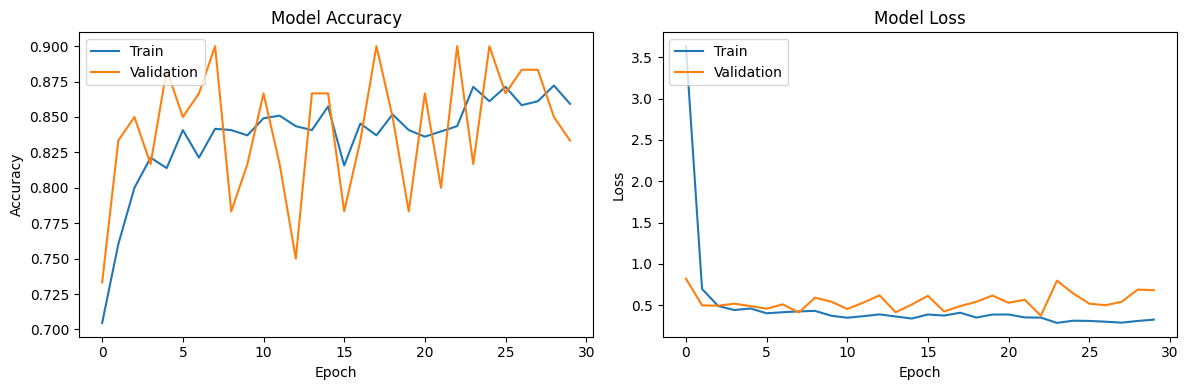

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


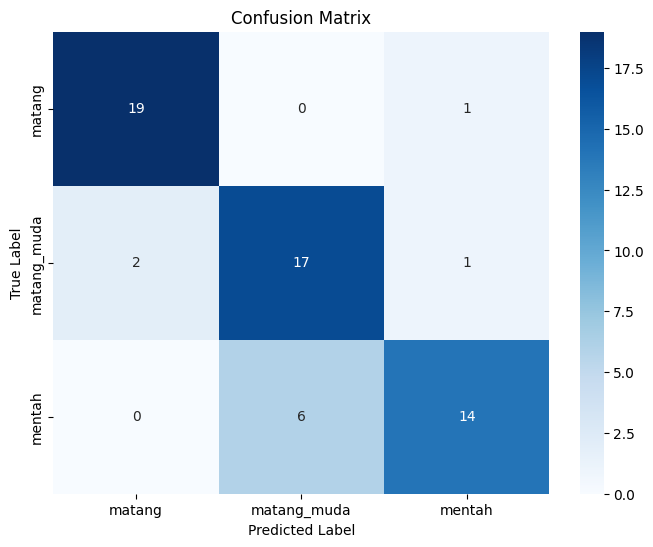

Classification Report:

              precision    recall  f1-score   support

      matang       0.90      0.95      0.93        20
 matang_muda       0.74      0.85      0.79        20
      mentah       0.88      0.70      0.78        20

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the model
model = load_model('vgg19_model1.h5')
# Prediksi pada data uji
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Tampilkan classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


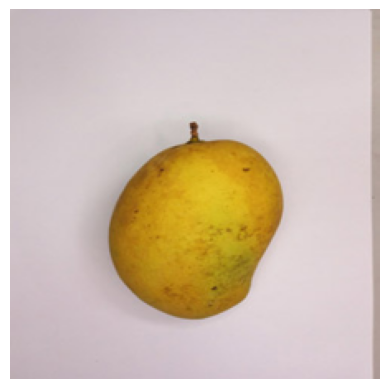

Predicted class: matang
Confidence: 1.0


In [44]:
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan memproses gambar dengan penyesuaian dimensi
def load_and_process_image(image_path):
    # Memuat gambar
    img = Image.open(image_path)
    
    # Penyesuaian dimensi jika diperlukan
    if img.size != (224, 224):
        img = img.resize((224, 224))
    
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

# Fungsi untuk mendapatkan label prediksi
def get_predictions(image_path):
    processed_image = load_and_process_image(image_path)[0]
    pred = model.predict(processed_image)[0]  # Mengambil prediksi untuk satu gambar saja
    return pred

# Path ke gambar yang akan diprediksi
image_path = 'D:/ta-rafi/dataset_mangga/buat_test/matang.jpg'

# Melakukan prediksi
prediction = get_predictions(image_path)
processed_image, original_image = load_and_process_image(image_path)

# Menampilkan gambar
plt.imshow(original_image)
plt.axis('off')
plt.show()

# Menampilkan hasil prediksi
predicted_class_index = np.argmax(prediction)
predicted_class_name = ['matang', 'matang_muda', 'mentah'][predicted_class_index]
confidence = prediction[predicted_class_index]

print("Predicted class:", predicted_class_name)
print("Confidence:", confidence)
